In [ ]:
import operator
from typing import TypedDict, Annotated, List, Union
from langgraph.graph import StateGraph, END
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

load_dotenv()  # load environment variables from .env

# --- Environment Variable Checks ---
google_api_key_loaded = os.getenv("GOOGLE_API_KEY") is not None
MODEL="google_genai:gemini-2.0-flash"
llm = init_chat_model(MODEL)

# --- 1. Define the State ---
class WorkflowState(TypedDict):
    customer_feedback: str
    sentiment: Union[str, None]  # "Positive", "Negative", or None initially
    decision_made: Union[str, None] # "Escalation Triggered", "Thank You Sent", or None
    feedback_summary: Union[str, None]
    feedback_keywords: Union[List[str], None]
    final_response: Union[str, None]
    error: Union[str, None] # To capture any errors

In [38]:
def llm_classify_sentiment(feedback: str) -> str:
    """Simulates an LLM call to classify sentiment."""
    prompt = f"What is the sentiment of the following customer feedback: '{feedback}'? Reply with only 'positive' or 'negative'."
    sentiment_result = llm.invoke(prompt).content.strip().lower()
    print(sentiment_result)
    return sentiment_result
    # if "unhappy" in feedback.lower() or "poor" in feedback.lower() or "bad" in feedback.lower():
    #     return "Negative"
    # elif "happy" in feedback.lower() or "great" in feedback.lower() or "good" in feedback.lower():
    #     return "Positive"
    # return "Neutral" # Or handle as per your logic, for this example, we'll treat Neutral as Positive for simplicity


In [39]:
def llm_generate_summary(feedback: str) -> str:
    """Simulates an LLM call to generate a summary. (Placeholder)"""
    print(f"LLM (Placeholder): Generating summary for: '{feedback[:50]}...'")
    return f"Summary: The customer expressed feelings about their experience. Key point: {feedback.split('.')[0]}."


In [40]:
#  using llm call

def llm_generate_summary(feedback: str) -> str:
    """Simulates an LLM call to generate a summary. (Placeholder)"""
    generate_summary_prompt = f"""
    You are an expert summarization assistant. Your goal is to provide a concise and neutral summary of the customer feedback provided.
    Please summarize the following customer feedback: \n\n'{feedback}'
    """

    summary = llm.invoke(generate_summary_prompt).content.strip().lower()
    print(f"********* summary: {summary} **************")
    return summary



In [19]:
def llm_extract_keywords(feedback: str) -> List[str]:
    """Simulates an LLM call to extract keywords. (Placeholder)"""
    print(f"LLM (Placeholder): Extracting keywords for: '{feedback[:50]}...'\n")
    words = feedback.lower().replace('.', '').replace(',', '').split()
    keywords = [word for word in words if len(word) > 4 and word not in ["customer", "feedback", "their", "about"]]
    return list(set(keywords[:5]))

In [41]:
#  using llm call

def llm_extract_keywords(feedback: str) -> List[str]:
    """Simulates an LLM call to extract keywords. (Placeholder)"""
    extract_keywords_prompt = f"""
    You are an expert keyword extraction assistant. Your task is to identify and list the most important keywords or key phrases from the customer feedback. Please return them as a comma-separated list. Aim for 3-5 keywords/phrases.
    Extract the main keywords/key phrases from this customer feedback: \n\n'{feedback}'
    """ 
    keywords = llm.invoke(extract_keywords_prompt).content.strip().lower()
    print(f"********* keywords: {keywords} **************")
    return keywords

In [42]:
def classify_sentiment_node(state: WorkflowState) -> WorkflowState:
    print("--- Node: Classify Sentiment ---")
    feedback = state.get("customer_feedback")
    if not feedback:
        return {"error": "Customer feedback is missing."}

    sentiment_result = llm_classify_sentiment(feedback)
    print(f"Sentiment: {sentiment_result}\n")
    # Ensure the state stores the capitalized version if that's what the rest of the graph expects
    # sentiment = sentiment_result.capitalize() if sentiment_result in ["positive", "negative"]
    if sentiment_result in ["positive", "negative"]:
        sentiment_result = sentiment_result.capitalize()
    return {"sentiment": sentiment_result}

In [43]:
def trigger_support_escalation_node(state: WorkflowState) -> WorkflowState:
    print("--- Node: Trigger Support Escalation ---")
    print("Action: Support escalation process initiated.\n")
    return {"decision_made": "Escalation Triggered"}

def send_thank_you_acknowledgment_node(state: WorkflowState) -> WorkflowState:
    print("--- Node: Send Thank You Acknowledgment ---")
    print("Action: Thank you acknowledgment sent to the customer.\n")
    return {"decision_made": "Thank You Sent"}

def record_feedback_decision_node(state: WorkflowState) -> WorkflowState:
    print("--- Node: Record Feedback Decision ---")
    sentiment = state.get("sentiment")
    decision = state.get("decision_made")
    print(f"Recording: Sentiment '{sentiment}', Decision '{decision}'\n")
    return {}

def generate_feedback_summary_node(state: WorkflowState) -> WorkflowState:
    print("--- Node: Generate Feedback Summary ---")
    feedback = state.get("customer_feedback")
    if not feedback:
        return {"error": "Customer feedback is missing for summary generation."}
    summary = llm_generate_summary(feedback)
    print(f"Generated Summary: {summary}\n")
    return {"feedback_summary": summary}

def extract_feedback_keywords_node(state: WorkflowState) -> WorkflowState:
    print("--- Node: Extract Feedback Keywords ---")
    feedback = state.get("customer_feedback")
    if not feedback:
        return {"error": "Customer feedback is missing for keyword extraction."}
    keywords = llm_extract_keywords(feedback)
    print(f"Extracted Keywords: {keywords}\n")
    return {"feedback_keywords": keywords}

def finalize_workflow_response_node(state: WorkflowState) -> WorkflowState:
    print("--- Node: Finalize Workflow Response ---")
    summary = state.get("feedback_summary", "N/A")
    keywords = state.get("feedback_keywords", [])
    decision = state.get("decision_made", "N/A")
    sentiment = state.get("sentiment", "N/A")
    final_response_message = (
        f"Workflow Complete.\n"
        f"Sentiment: {sentiment}\n"
        f"Action Taken: {decision}\n"
        f"Feedback Summary: {summary}\n"
        f"Feedback Keywords: {keywords}\n"
        f"This information has been recorded."
    )
    print(final_response_message)
    return {"final_response": final_response_message}

In [44]:
def should_escalate(state: WorkflowState) -> str:
    print("--- Condition: Should Escalate? ---")
    if state.get("error"):
        print(f"Error detected: {state.get('error')}. Ending.")
        return "error_handler"

    sentiment = state.get("sentiment")
    # The conditional logic expects "Negative", "Positive", etc. (capitalized)
    if sentiment == "Negative":
        print("Decision: Escalate.\n")
        return "trigger_escalation"
    else: # Positive or Neutral
        print("Decision: Send Thank You.\n")
        return "send_thank_you"

In [45]:
workflow_builder = StateGraph(WorkflowState)

workflow_builder.add_node("classify_sentiment", classify_sentiment_node)
workflow_builder.add_node("trigger_escalation", trigger_support_escalation_node)
workflow_builder.add_node("send_thank_you", send_thank_you_acknowledgment_node)
workflow_builder.add_node("record_decision", record_feedback_decision_node)
workflow_builder.add_node("generate_summary", generate_feedback_summary_node)
workflow_builder.add_node("extract_keywords", extract_feedback_keywords_node)
workflow_builder.add_node("finalize_response", finalize_workflow_response_node)

workflow_builder.set_entry_point("classify_sentiment")

workflow_builder.add_conditional_edges(
    "classify_sentiment",
    should_escalate,
    {
        "trigger_escalation": "trigger_escalation",
        "send_thank_you": "send_thank_you",
        "error_handler": END
    }
)

workflow_builder.add_edge("trigger_escalation", "record_decision")
workflow_builder.add_edge("send_thank_you", "record_decision")
workflow_builder.add_edge("record_decision", "generate_summary")
workflow_builder.add_edge("record_decision", "extract_keywords")
workflow_builder.add_edge("generate_summary", "finalize_response")
workflow_builder.add_edge("extract_keywords", "finalize_response")
workflow_builder.add_edge("finalize_response", END)

workflow = workflow_builder.compile()

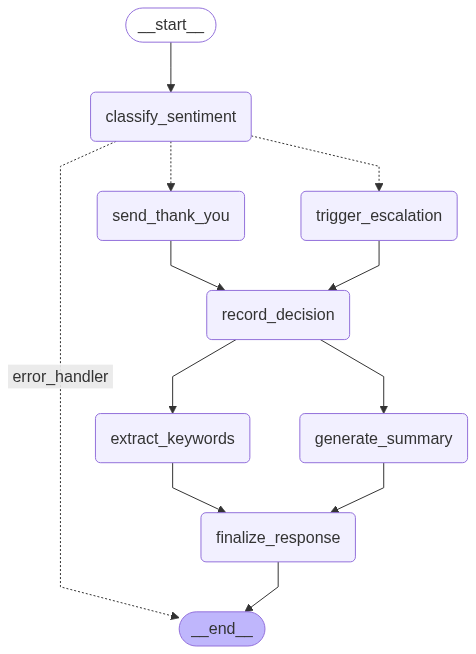

In [32]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [49]:
print("--- Starting Workflow with Positive Feedback ---")
positive_feedback = "I am very happy with the service! It was great and the support was excellent."
inputs_positive = {"customer_feedback": positive_feedback}
final_state_positive = workflow.invoke(inputs_positive)
print("\nFinal State (Positive Feedback):")
print(final_state_positive.get('final_response'))


--- Starting Workflow with Positive Feedback ---
--- Node: Classify Sentiment ---
positive
Sentiment: positive

--- Condition: Should Escalate? ---
Decision: Send Thank You.

--- Node: Send Thank You Acknowledgment ---
Action: Thank you acknowledgment sent to the customer.

--- Node: Record Feedback Decision ---
Recording: Sentiment 'Positive', Decision 'Thank You Sent'

--- Node: Extract Feedback Keywords ---
--- Node: Generate Feedback Summary ---
********* keywords: happy with the service, great support, excellent support **************
Extracted Keywords: happy with the service, great support, excellent support

********* summary: the customer expressed strong satisfaction with the service and support received. **************
Generated Summary: the customer expressed strong satisfaction with the service and support received.

--- Node: Finalize Workflow Response ---
Workflow Complete.
Sentiment: Positive
Action Taken: Thank You Sent
Feedback Summary: the customer expressed strong s

In [50]:
print("\n\n--- Starting Workflow with Negative Feedback ---")
negative_feedback = "This is unacceptable. The product is poor and I am very unhappy with the experience."
inputs_negative = {"customer_feedback": negative_feedback}
final_state_negative = workflow.invoke(inputs_negative)
print("\nFinal State (Negative Feedback):")
print(final_state_negative.get('final_response'))



--- Starting Workflow with Negative Feedback ---
--- Node: Classify Sentiment ---
negative
Sentiment: negative

--- Condition: Should Escalate? ---
Decision: Escalate.

--- Node: Trigger Support Escalation ---
Action: Support escalation process initiated.

--- Node: Record Feedback Decision ---
Recording: Sentiment 'Negative', Decision 'Escalation Triggered'

--- Node: Extract Feedback Keywords ---
--- Node: Generate Feedback Summary ---
********* keywords: unacceptable, poor product, unhappy experience **************
Extracted Keywords: unacceptable, poor product, unhappy experience

********* summary: the customer expresses strong dissatisfaction with the product and overall experience, describing the product as poor and the experience as unacceptable. **************
Generated Summary: the customer expresses strong dissatisfaction with the product and overall experience, describing the product as poor and the experience as unacceptable.

--- Node: Finalize Workflow Response ---
Wor